In [1]:

import pandas
import os
from metric_utils import *
import torch
import ast
import numpy as np
from swarm_visualizer.boxplot import  plot_paired_boxplot
from swarm_visualizer.utility.general_utils import save_fig, set_plot_properties
from matplotlib import pyplot as plt

In [12]:
FOLDER = '../tests/'
files = os.listdir(FOLDER)
WAYMO_PALLETE = {
            'undefined' : [0, 0, 0],#1
            'ego_vehicle': [102, 102, 102],#2
            'car': [0, 0, 142], #3
            'truck': [0, 0, 70], #4
            'bus': [0, 60, 100],#5
            'other_large_vehicle': [61, 133, 198],#
            'bicycle': [119, 11, 32],#
            'motorcycle': [0, 0, 230],#
            'trailer': [111, 168, 220],#
            'pedestrian': [220, 20, 60],#10
            'cyclist': [255, 0, 0],#
            'motorcyclist': [180, 0, 0],#
            'bird': [127, 96, 0],#
            'ground_animal': [91, 15, 0],#
            'construction_cone_pole': [230, 145, 56],#15
            'pole': [153, 153, 153],#
            'pedestrian_object': [234, 153, 153],#
            'sign': [246, 178, 107],#
            'traffic_light': [250, 170, 30],#
            'building': [70, 70, 70],#20
            'road': [128, 64, 128],#
            'lane_marker': [234, 209, 220],#
            'road_marker': [217, 210, 233],#
            'sidewalk': [244, 35, 232],#
            'vegetation': [107, 142, 35],#25
            'sky': [70, 130, 180],#
            'ground': [102, 102, 102],#
            'dynamic': [102, 102, 102],#
            'static': [102, 102, 102]#
        }
WAYMO_CLASSES = np.array(list(WAYMO_PALLETE.keys()))
COMPUTE_CLASSES = np.arange(len(WAYMO_CLASSES))[2:-3]
print(WAYMO_CLASSES[COMPUTE_CLASSES])


['car' 'truck' 'bus' 'other_large_vehicle' 'bicycle' 'motorcycle'
 'trailer' 'pedestrian' 'cyclist' 'motorcyclist' 'bird' 'ground_animal'
 'construction_cone_pole' 'pole' 'pedestrian_object' 'sign'
 'traffic_light' 'building' 'road' 'lane_marker' 'road_marker' 'sidewalk'
 'vegetation' 'sky']


In [13]:
MODEL_DATA= dict()
for file in files:
    if file.endswith('.csv'):
        model = file.split('.')[0]
        df = pandas.read_csv(FOLDER + file)
        # Convert each relevant column to a Torch tensor
        MODEL_DATA[model] = df
        print(len(df))
        print(df.groupby('condition').size())
    
def string_to_tensor(tensor_string):
    # Convert string representation of a tensor to an actual tensor
    # Use ast.literal_eval to safely evaluate the string
    array_list = [float(item) for item in tensor_string.strip("[]").split()]

    # Convert the list to a NumPy array
    np_array = np.array(array_list)

    # Convert the NumPy array to a PyTorch tensor
    tensor = torch.tensor(np_array)
    return tensor

def stack_sum_tensors(series):
    return torch.stack(series, dim=0).sum(dim=0).detach().cpu().numpy()

def mean_metrics(series, class_idx):
    #ignore nans when computing the mean
    
    series[np.isinf(series)] = np.nan
    #print(series[class_idx])
    return np.nanmean(series[class_idx]).item()

def std_metrics(series, class_idx):
    #ignore nans when computing the mean
    series[np.isinf(series)] = np.nan
    return np.nanstd(series[class_idx]).item()

def accumulate(series, class_idx):
    #ignore nans when computing the mean
    series[np.isinf(series)] = np.nan
    #print(series)
    #Only return the series for class_idx and non nan values
    series2 = series[class_idx]
    return series2[~np.isnan(series2)].tolist()


5790
condition
Clear, Dawn/Dusk      213
Clear, Day           4201
Clear, Night          115
Cloudy, Dawn/Dusk      47
Cloudy, Day           129
Cloudy, Night          48
Rainy, Dawn/Dusk      322
Rainy, Day            416
Rainy, Night          299
dtype: int64
5790
condition
Clear, Dawn/Dusk      213
Clear, Day           4201
Clear, Night          115
Cloudy, Dawn/Dusk      47
Cloudy, Day           129
Cloudy, Night          48
Rainy, Dawn/Dusk      322
Rainy, Day            416
Rainy, Night          299
dtype: int64
5790
condition
Clear, Dawn/Dusk      213
Clear, Day           4201
Clear, Night          115
Cloudy, Dawn/Dusk      47
Cloudy, Day           129
Cloudy, Night          48
Rainy, Dawn/Dusk      322
Rainy, Day            416
Rainy, Night          299
dtype: int64


In [4]:
MODEL_DATA[list(MODEL_DATA.keys())[0]].columns

Index(['context_name', 'context_frame', 'camera_id', 'condition',
       'mIoU_intersect', 'mIoU_union', 'mIoU_pred_label', 'mIoU_label'],
      dtype='object')

In [14]:

avg_metrics_df = pandas.DataFrame(columns=['model','condition', 'accuracy', 'IoU', 'Dice', 'F1'])
avg_metrics_df['model'] = MODEL_DATA.keys()
tensor_columns = ['mIoU_intersect', 'mIoU_union', 'mIoU_pred_label', 'mIoU_label'] 
metrics_column = ['accuracy', 'IoU', 'Dice', 'F1']
avg_metrics_col = ['mAcc','mIoU', 'mDice', 'mF1']

data_plot = dict()
for model, data in MODEL_DATA.items():
    print('RESULTS FOR MODEL: ', model)
    metrics_df = pandas.DataFrame(columns=['condition', 'accuracy', 'IoU', 'Dice', 'F1'])
    # List of tensor columns


# Convert tensor columns from string to actual tensors
    for col in tensor_columns:
        data[col] = data[col].apply(string_to_tensor)
    

    grouped_data = data.groupby('condition')[tensor_columns]
    grouped_data = grouped_data.agg(list)
    num_items = grouped_data.applymap(len)
    grouped_sum = grouped_data.applymap(stack_sum_tensors)
    # print(grouped_sum['mIoU_intersect'])
    # print(num_items)

    # print(grouped_sum['mIoU_intersect']/grouped_sum['mIoU_label'])
    # print(compute_accuracy(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_label']))
    grouped_sum['accuracy'] = compute_accuracy(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_label'])
    grouped_sum['IoU'] = compute_IOU(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_union'])
    grouped_sum['Dice'] = compute_DICE(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_union'])
    grouped_sum['F1'] = compute_F1(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_pred_label'], grouped_sum['mIoU_label'])
    metrics_df = grouped_sum[metrics_column]
    
    metrics_df_post = metrics_df.copy()
    metrics_df_post['accuracy']= metrics_df['accuracy'].apply(accumulate, class_idx=COMPUTE_CLASSES)
    metrics_df_post['IoU'] = metrics_df['IoU'].apply(accumulate, class_idx=COMPUTE_CLASSES)
    metrics_df_post['Dice']= metrics_df['Dice'].apply(accumulate, class_idx=COMPUTE_CLASSES)
    metrics_df_post['F1']= metrics_df['F1'].apply(accumulate, class_idx=COMPUTE_CLASSES)
    data_plot[model] = metrics_df_post
    # set metrics_df columns to class names
    #print(grouped_sum['accuracy'])
    # print(metrics_df)
    
    metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mIoU'] = metrics_df['IoU'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mDice'] = metrics_df['Dice'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mF1'] = metrics_df['F1'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdAcc'] = metrics_df['accuracy'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdIoU'] = metrics_df['IoU'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdDice'] = metrics_df['Dice'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdF1'] = metrics_df['F1'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    avg_metrics_df = metrics_df[avg_metrics_col]
    print(avg_metrics_df)
    # metrics_df['accuracy'] = compute_accuracy(total_area_intersect.astype(float), total_area_gt_label.astype(float))
    # metrics_df['IoU'] = compute_IOU(total_area_intersect.astype(float), total_area_union.astype(float))
    # metrics_df['Dice'] = compute_DICE(total_area_intersect.astype(float), total_area_union.astype(float))
    # metrics_df['F1'] = compute_F1(total_area_intersect.astype(float), total_area_pred_label.astype(float), total_area_gt_label.astype(float))
    # # Add new columns to the dataframe with the metrics
    # avg_metrics_df['condition'] = metrics_df['condition']
    # avg_metrics_df['accuracy'] = metrics_df['accuracy'].mean()
    # avg_metrics_df['IoU'] = metrics_df['IoU'].mean()
    # avg_metrics_df['Dice'] = metrics_df['Dice'].mean()
    # avg_metrics_df['F1'] = metrics_df['F1'].mean()




RESULTS FOR MODEL:  mask2former_r50_8xb2-90k_mixedwaymo-512x512


/tmp/ipykernel_222455/200492041.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_222455/200492041.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mIoU'] = metrics_df['IoU'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_222455/200492041.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

                       mAcc      mIoU     mDice       mF1
condition                                                
Clear, Dawn/Dusk   0.553892  0.466092  0.546701  0.717545
Clear, Day         0.553546  0.479776  0.565621  0.617041
Clear, Night       0.593805  0.384124  0.488484  0.651312
Cloudy, Dawn/Dusk  0.610266  0.499251  0.571902  0.747872
Cloudy, Day        0.658482  0.532887  0.612409  0.709105
Cloudy, Night      0.501966  0.380769  0.482147  0.602683
Rainy, Dawn/Dusk   0.436823  0.375462  0.450205  0.647170
Rainy, Day         0.626278  0.499931  0.590606  0.714944
Rainy, Night       0.477248  0.328909  0.421892  0.632837
RESULTS FOR MODEL:  mask2former_r50_8xb2-90k_waymo-512x512


/tmp/ipykernel_222455/200492041.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_222455/200492041.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mIoU'] = metrics_df['IoU'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_222455/200492041.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

                       mAcc      mIoU     mDice       mF1
condition                                                
Clear, Dawn/Dusk   0.541850  0.394731  0.461816  0.692724
Clear, Day         0.574014  0.484513  0.565643  0.617065
Clear, Night       0.623956  0.362063  0.455432  0.683148
Cloudy, Dawn/Dusk  0.607682  0.472812  0.544853  0.700525
Cloudy, Day        0.624848  0.496241  0.568656  0.688373
Cloudy, Night      0.521379  0.388994  0.485733  0.607166
Rainy, Dawn/Dusk   0.459724  0.378715  0.451253  0.676879
Rainy, Day         0.643473  0.474650  0.567750  0.681300
Rainy, Night       0.559722  0.362699  0.463255  0.628704
RESULTS FOR MODEL:  mask2former_r50_8xb2-90k_synthwaymo-512x512
                       mAcc      mIoU     mDice       mF1
condition                                                
Clear, Dawn/Dusk   0.447534  0.345847  0.421314  0.545230
Clear, Day         0.491314  0.375788  0.468561  0.535498
Clear, Night       0.540961  0.301917  0.403552  0.571698
Cloudy, 

/tmp/ipykernel_222455/200492041.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_222455/200492041.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mIoU'] = metrics_df['IoU'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_222455/200492041.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [15]:
# Formatting data plot items
for model, data in data_plot.items():
    data['model'] = model
    # print(data.columns)
    # print(data.index)
    data.reset_index(inplace=True)
    print(data.index)
    print(data.columns)
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data = pd.concat([dfs for dfs in data_plot.values()], ignore_index=True)

RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model'], dtype='object')
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model'], dtype='object')
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model'], dtype='object')


                                          model         condition  accuracy
0   mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk  0.974411
0   mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk   0.70793
0   mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk       0.0
0   mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk       0.0
0   mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk       0.0
..                                          ...               ...       ...
26  mask2former_r50_8xb2-90k_synthwaymo-512x512      Rainy, Night  0.120494
26  mask2former_r50_8xb2-90k_synthwaymo-512x512      Rainy, Night  0.308731
26  mask2former_r50_8xb2-90k_synthwaymo-512x512      Rainy, Night  0.654402
26  mask2former_r50_8xb2-90k_synthwaymo-512x512      Rainy, Night  0.788701
26  mask2former_r50_8xb2-90k_synthwaymo-512x512      Rainy, Night  0.626715

[507 rows x 3 columns]


/home/hg22723/anaconda3/envs/control-v11.8/lib/python3.9/site-packages/swarm_visualizer/boxplot.py:59: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(


Text(0.5, 0, 'TL Specification')

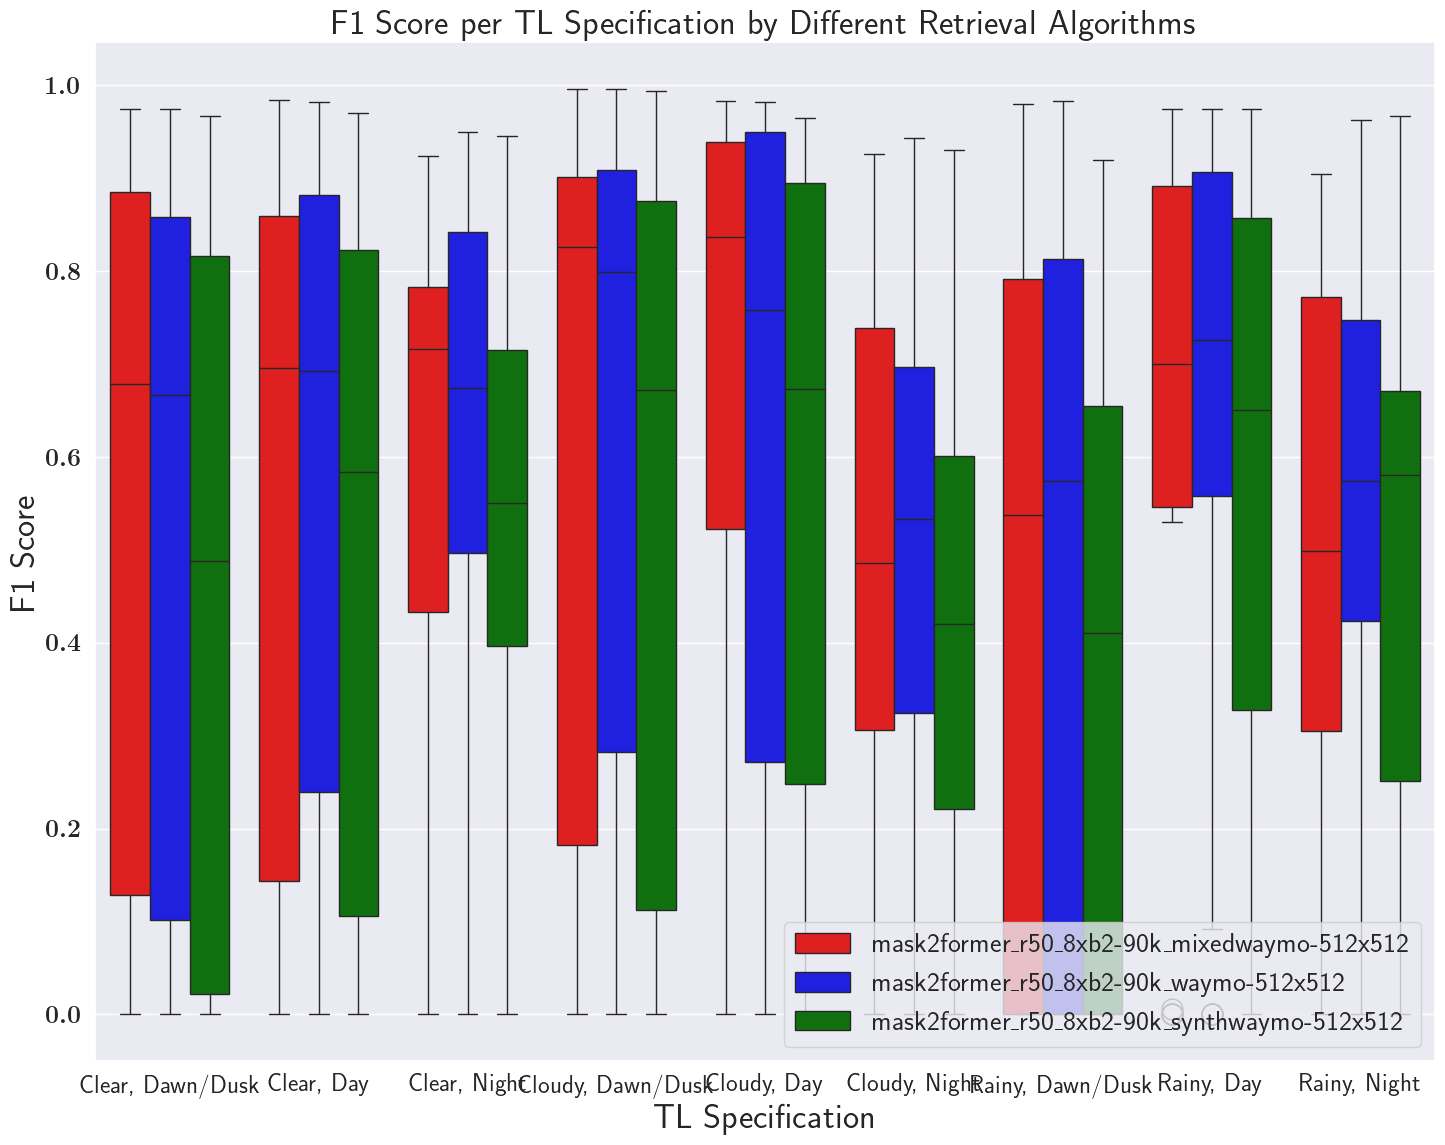

In [17]:
# Plotting the results in a box plot
# Combine the dataframes into a single dataframe in data_plot



all_data_acc = pd.DataFrame(columns=['model', 'condition', 'accuracy'])
all_data_acc['model'] = all_data['model']
all_data_acc['condition'] = all_data['condition']
all_data_acc['accuracy'] = all_data['accuracy']
all_data_acc = all_data_acc.explode('accuracy')

print(all_data_acc)
set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))
plot_paired_boxplot(all_data_acc,
                    x_var='condition',
                    y_var='accuracy', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'F1 Score per LTL Group by Different Retrieval Models',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('F1 Score per TL Specification by Different Retrieval Algorithms', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlabel('TL Specification', fontsize=25)


/home/hg22723/anaconda3/envs/control-v11.8/lib/python3.9/site-packages/swarm_visualizer/boxplot.py:59: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(


Text(0.5, 0, 'Condition')

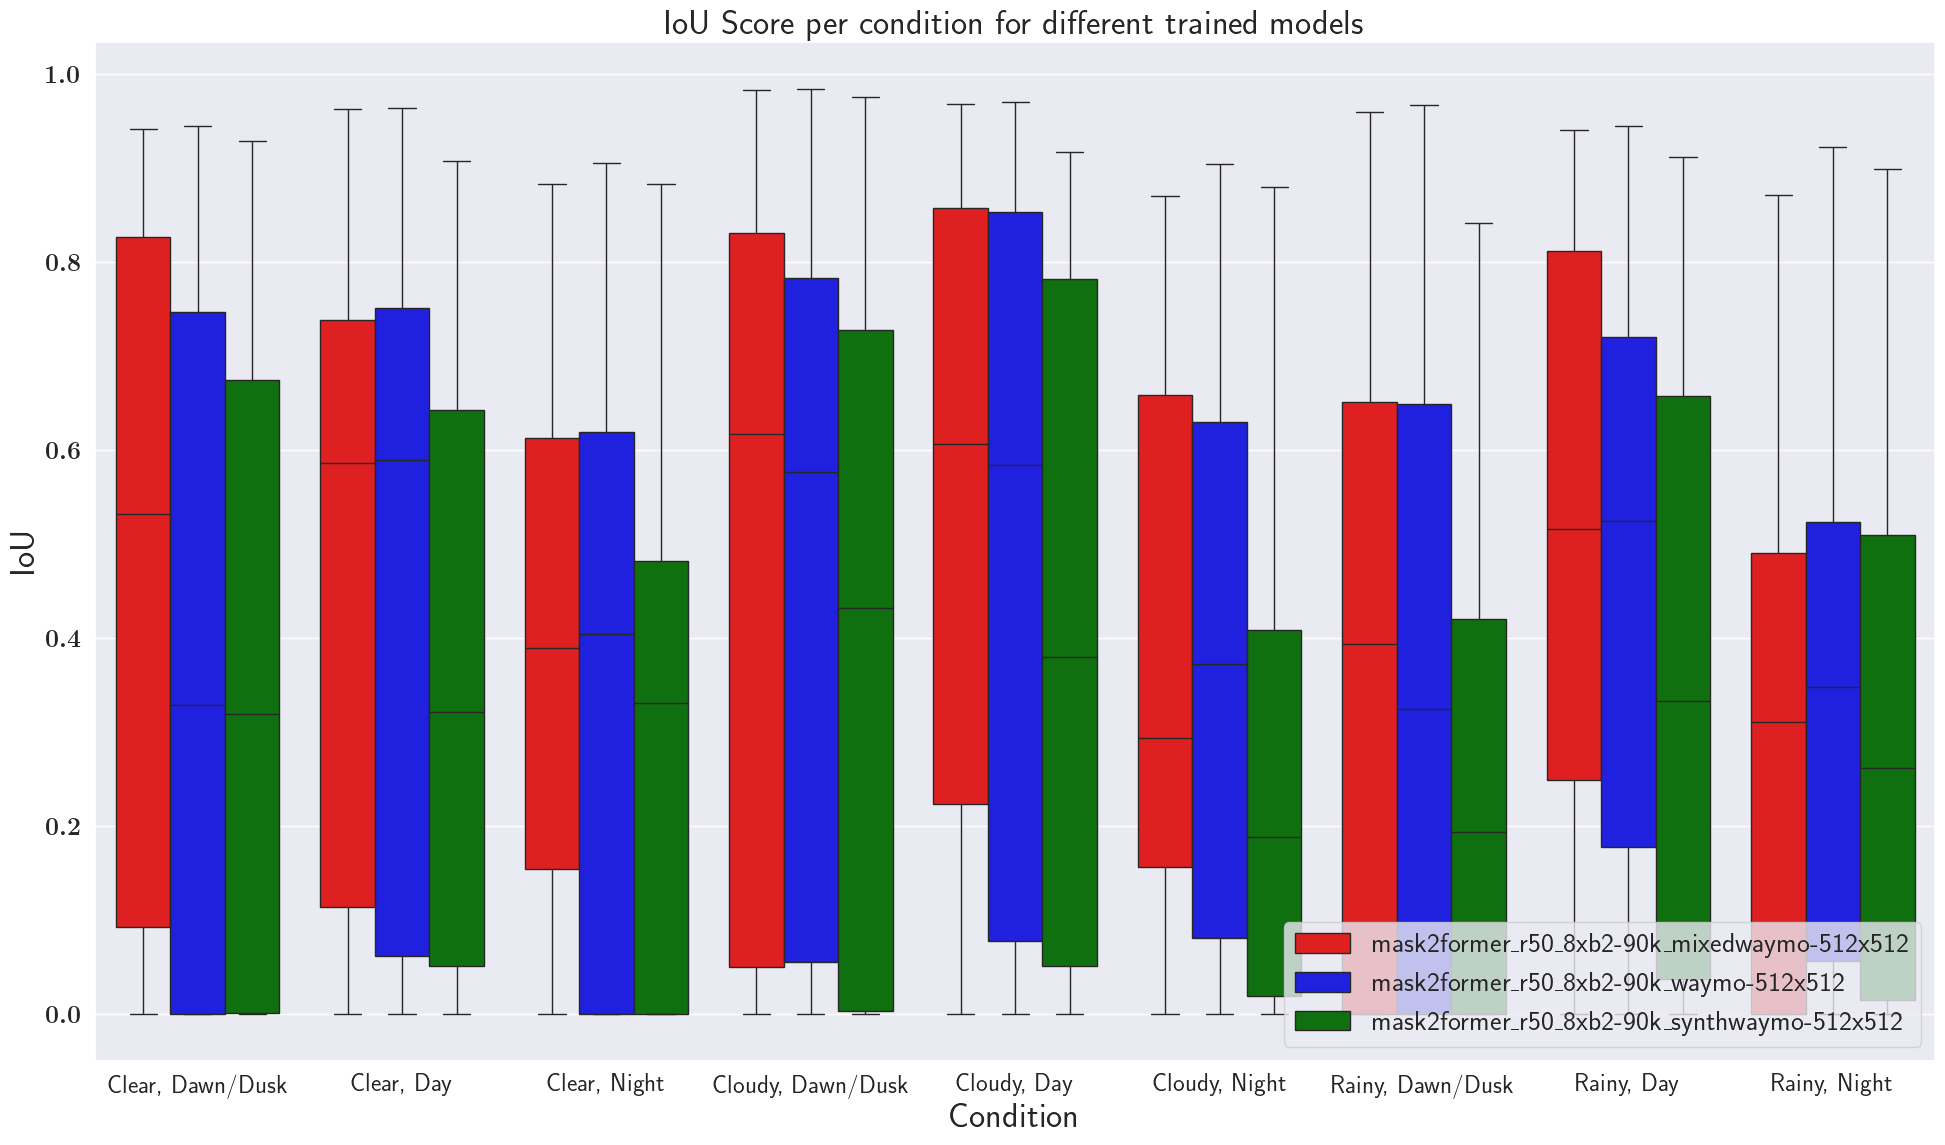

In [22]:
all_data_iou = pd.DataFrame(columns=['model', 'condition', 'IoU'])
all_data_iou['model'] = all_data['model']
all_data_iou['condition'] = all_data['condition']
all_data_iou['IoU'] = all_data['IoU']

all_data_iou = all_data_iou.explode('IoU')
set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(20, 12))
plot_paired_boxplot(all_data_iou,
                    x_var='condition',
                    y_var='IoU', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'IoU per conditions',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('IoU Score per condition for different trained models', fontsize=25)
plt.ylabel('IoU', fontsize=25)
plt.xlabel('Condition', fontsize=25)



In [ ]:
all_data_dice = pd.DataFrame(columns=['model', 'condition', 'Dice'])
all_data_dice['model'] = all_data['model']
all_data_dice['condition'] = all_data['condition']
all_data_dice['Dice'] = all_data['Dice']

set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))
plot_paired_boxplot(all_data_iou,
                    x_var='condition',
                    y_var='Dice', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'F1 Score per LTL Group by Different Retrieval Models',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('F1 Score per TL Specification by Different Retrieval Algorithms', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlabel('TL Specification', fontsize=25)


In [ ]:
all_data_f1 = pd.DataFrame(columns=['model', 'condition', 'F1'])
all_data_f1['model'] = all_data['model']
all_data_f1['condition'] = all_data['condition']
all_data_f1['F1'] = all_data['F1']

set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))
plot_paired_boxplot(all_data_iou,
                    x_var='condition',
                    y_var='F1', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'F1 Score per LTL Group by Different Retrieval Models',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('F1 Score per TL Specification by Different Retrieval Algorithms', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlabel('TL Specification', fontsize=25)


# Correcting the set of conditions


In [8]:
DF_COND = MODEL_DATA[list(MODEL_DATA.keys())[0]]
columns = ['content_name', 'context_frame', 'camera_id','condition']
data = DF_COND[columns]

# Save the data to a compiled CSV file


In [ ]:
print(total_area_intersect.items)
print(len(total_area_intersect))